# SpaceCharger

In [1]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.stats import gaussian_kde
import scipy.stats as stats
from typing import Callable, Literal, Optional
from numpy.typing import NDArray
%matplotlib inline

# my own little library for dealing with four vectors
import fourvectors as fv

# numba!
from numba import jit, prange

## Constants & Enums

In [2]:
### Constants
c = 3E8
EPSILON_0 = 8.85E-12
COULOMB_K = 1 / (4 * np.pi * EPSILON_0)

### Create enums of particle properties, could be useful for multi-species experiments
class Proton(Enum):
    NAME   = "PROTON"
    MASS   = 1.672E-27 #kg
    CHARGE = 1.602E-19 #C

class Electron(Enum):
    NAME   = "ELECTRON"
    MASS   = 9.109E-21 #kg
    CHARGE =-1.602E-19 #C

class Reference(Enum):
    """A particle that is simply here to be a reference point."""
    NAME   = "REFERENCE PARTICLE"
    MASS   = 0        #kg
    CHARGE = 0        #C

## Particle Class

In [3]:
### Create the particle class, this holds all of the nice info about each particle
class Particle():
    def __init__(
            self,
            species,
            pos0_3v = None,  # a three-position
            pos0_4v = None,  # a four-position
            v0_3v  = None,   # a three-velocity
            v0_4v  = None,   # a four-velocity
            frame  = "LAB"   # defaults to lab frame
        ):

        ### HANDLE INITIAL VELOCITIES

        # if no initial three-velocity specified, assume 0
        if v0_3v is None or v0_4v is None:
            v0_4v = np.array([0, 0, 0, 0])

        # if there is a 3v provided, convert it
        if v0_3v is not None:
            # otherwise set the four velocity to match it
            v0_4v = fv.to_four_velocity(v0_3v)

        ### HANDLE INITIAL POSITIONS

        # if no position specified, assume origin
        if pos0_3v is None or pos0_4v is None:
            pos0_4v = np.array([0, 0, 0, 0])

        # if there is a pos 3v provided, convert it
        if pos0_3v is not None:
            pos0_4v = fv.to_four_position(pos0_3v, 0)

        # Get the parameters from the species of particle
        self.name = species.NAME.value
        self.mass = species.MASS.value
        self.charge = species.CHARGE.value

        self.vel_4v = v0_4v    # four velocity
        self.pos_4v = pos0_4v  # four position
        self.frame  = frame

    ### Lorentz Boost Functionality
    def lorentz_boost_to(self, other):
        """Lorentz boost to another particle's frame"""
        # if the frame is lab, then we're boosting to another particle
        if self.frame == "LAB":
            self.frame = other.name
        else:
            self.frame = other.frame

        # first lorentz boost the velocity
        self.lorentz_boost_from_4v(other.vel_4v)

        # then shift it
        if self.name == "REFERENCE PARTICLE":
            # here, the particle is the reference, and becomes the new reference frame
            self.pos_4v = self.get_separation(other)
        else:
            # otherwise lorentz the separation vector given the velocity of the other
            # (likely the reference)
            self.pos_4v = np.linalg.matmul(
                    fv.lorentz_matrix_z_4v(other.vel_4v), self.get_separation(other)
                )

    def boost_as_reference(self):
        self.lorentz_boost_to(self)

    def lorentz_boost_from_4v(self, to_vel_4v):
        """Lorentz boost given a four-velocity"""
        lorentz_matrix = fv.lorentz_matrix_z_4v(to_vel_4v)
        self.vel_4v = np.linalg.matmul(lorentz_matrix, self.vel_4v)

    def lorentz_boost_from_3v(self, to_vel_3v):
        """Lorentz boost given a three-velocity"""
        self.lorentz_boost_from_4v(fv.to_four_velocity(to_vel_3v))

    def get_separation(self, other):
        """"get the separation vector between the two positions"""
        return self.pos_4v - other.pos_4v

    ### Getters
    def get_3v(self):
        return fv.to_three_velocity(self.vel_4v)

    def get_3p(self):
        return fv.to_three_position(self.pos_4v)

## Multi-Gaussian Fitting Regiment

In [4]:
gaussian = lambda x, sig, mu: np.exp(-(x - mu)**2/(2 * sig**2))

def plotNormalWithLine(s, sig=None, mu=None, title=None, opacity=None):
    _, bins, _ = plt.hist(s, 50, density=True, label = title, alpha = opacity)

    if sig is not None and mu is not None:
        plt.plot(bins, 1/(sig * np.sqrt(2 * np.pi)) *
                    np.exp( - (bins - mu)**2 / (2 * sig**2) ),
                linewidth=2, color='r')

class MultiGaussFit():
    def __init__(
                    self,
                    arr,
                    nbins:int = 50,
                    ngaussians:int = 1,
                    width:float = 10.0,
                    mesh = None
                ):

        # get the histogram and bins arrays from the input array
        histo, bins = np.histogram(arr, bins=nbins, density=True)

        # bins = (bins[1:] + bins[:-1])/2

        # if no mesh specified, then overwrite it with a guess
        if mesh is None:
            self.mesh = np.linspace(bins[0], bins[-1], 100000)
            print(f"[INFO] NO MESH SPECIFIED. ASSUMING: N=100000, \
                RANGE=({bins[0]}, {bins[-1]})")
        # if there IS a mesh, then sanitize it
        else:
            print(f"[INFO] MESH SPECIFIED. CHECKING...", end="")
            self._mesh_isclean(mesh)
            # if the mesh is clean, then we good
            self.mesh = mesh


        # set up the array that contains where the gaussians will be centered
        eval_pts = np.zeros((ngaussians, 2))

        # first seed where the gaussians should probably be
        guesses = np.linspace(bins[1], bins[-2], ngaussians)

        # create a place to hold that gaussian fit
        fitted_line = 0
        normsum = 0
        for i in range(ngaussians):
            # get the index of the values closest
            lower_index = int((guesses[i] - bins[0])/(bins[1] - bins[0]))

            # then place the gaussian's peak location at
            eval_pts[i] = (
                (bins[lower_index]+bins[lower_index+1])/2,
                histo[lower_index]
                ) # (loc, amplitude)

            # create the gaussians
            fitted_line += eval_pts[i][1] * gaussian(self.mesh, sig=width,
                                                        mu=eval_pts[i][0])
            normsum += eval_pts[i][1] * (width * np.sqrt(2 * np.pi))

        fitted_line /= normsum

        # store the input params for future use
        self.arr = arr
        self.ngaussians = ngaussians
        self.nbins = nbins
        self.width = width

        # store the important calculated things
        self.histo = histo
        self.bins = bins
        self.fitted_line = np.array(fitted_line, dtype=np.float64)

    def _mesh_isclean(self, mesh):
        """Ensures the mesh provided is uniformly spaced and monotonically increasing."""
        #uniform spacing check
        dx = np.diff(mesh)
        if not (np.allclose(dx, dx[0]) and np.all(dx > 0)):
            raise ValueError("Mesh is not clean!!!")
        else:
            print(" (PASS)")

    def __call__(self, val, pltpoint = None):
        # get the closest point on the mesh
        # get the index of the values closest

        # clamp the value to be in the mesh range
        val = np.clip(val, self.mesh[0], self.mesh[-1])

        lower_index = int((val - self.mesh[0])/(self.mesh[1] - self.mesh[0]))

        # if the user wants to plot where they're getting the value
        if pltpoint is not None:
            plt.plot(self.mesh[lower_index], self.fitted_line[lower_index], "kx")

        return self.fitted_line[lower_index]

    def scale_by_factor(self, num):
        """Returns a new MultiGaussFit instance with the same fitted shape
        but scaled by num."""
        # Create a shallow copy
        new = MultiGaussFit.__new__(MultiGaussFit)

        # Copy all fields (except for the fitted line, which we'll scale)
        new.arr = self.arr
        new.nbins = self.nbins
        new.ngaussians = self.ngaussians
        new.width = self.width
        new.mesh = self.mesh
        new.bins = self.bins

        # Scale the PDF by a factor
        new.histo = self.histo * num
        new.fitted_line = self.fitted_line * num

        return new

    def plot_fit(self):
        # plot the where the peaks of the gaussians should be
        plt.stairs(self.histo, self.bins)
        # plt.plot(eval_pts[:,0], eval_pts[:,1], 'kx',  markersize=12)
        plt.plot(self.mesh, self.fitted_line, 'r-')

## Quadrature Rules
I ran some ```%%timeit``` tests on each of the quadrature rules here.

---
### Test 1 (Scalar)

~~~python
%%timeit
gaussQuad1D(fxn=lambda x: 10, x_bounds=np.array([-1.0, 1.0]), n=100)
~~~
Returns:
~~~
1.63 ms ± 40 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
~~~

~~~python
%%timeit
call_jit1DConst(
    x_bounds=np.array([-1.0, 1.0]),
    n=100,
    const=10.0
)
~~~
Returns:
~~~
2.02 ms ± 52.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
~~~

Speedup:  <span style="color:red">No</span>!

---

### Test 2
~~~python
%%timeit
gaussQuad3DCylVec(
    fxn = lambda s, z, phi : np.array([s,z,phi]),
    s_bounds = np.array([0, 4]),
    z_bounds = np.array([0, 10]),
    phi_bounds = np.array([0, 2*np.pi]),
    n=40
)
~~~
Returns:
~~~
228 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
~~~

~~~python
%%timeit
call_jit3DCylVec(
    s_bounds = np.array([0, 4]),
    z_bounds = np.array([0, 10]),
    phi_bounds = np.array([0, 2*np.pi]),
    n=40
)
~~~
Returns:
~~~
2.06 ms ± 171 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
~~~

Speedup: <span style="color:lime">Yes</span>!

---

In [5]:
from numpy.polynomial.legendre import leggauss

def linTransform(
        t:float,
        a:float,
        b:float ) -> float:
    """Linear transform from [-1,1] to [a,b]"""
    return 0.5 * ((b - a) * t + (a + b))

def gaussQuad1D(
    fxn: Callable[[float], float],
    x_bounds:NDArray[np.float64],
    n:int = 3 ) -> float:
    """1-D Gaussian Quadrature using Legendre Polynomials.
    Defaults to 1 quadrature point."""
    roots, weights = leggauss(n)

    a, b = x_bounds

    sum = 0
    # perform the summation
    for i in range(n):
        # get the roots into a,b from -1,1
        u = linTransform(roots[i], a, b)
        sum += weights[i] * fxn(u)

    # multiply by the coefficents from the variable substitution
    return 0.5 * (b - a) * sum

def gaussQuad3DVec(
        fxn: Callable[[float, float, float], NDArray[np.float64]],
        x_bounds: NDArray[np.float64],
        y_bounds: NDArray[np.float64],
        z_bounds: NDArray[np.float64],
        n: int = 3 ) -> NDArray[np.float64]:
    """Gaussian Quadrature of a 3D Vector Function. Defaults to 3 quadrature points."""
    roots, weights = leggauss(n)
    ax, bx = x_bounds
    ay, by = y_bounds
    az, bz = z_bounds

    result = np.zeros(3)

    for i in range(n):
        # get the root from -1->1 to ax->bx
        x = linTransform(roots[i], ax, bx)
        wx = weights[i]
        for j in range(n):
            y = linTransform(roots[j], ay, by)
            wy = weights[j]
            for k in range(n):
                z = linTransform(roots[k], az, bz)
                wz = weights[k]

                result += wx * wy * wz * np.array(fxn(x, y, z))

    scale = 0.125 * (bx - ax) * (by - ay) * (bz - az)
    return scale * result

def gaussQuad3DCylVec(
        fxn: Callable[[float, float, float], NDArray[np.float64]],
        s_bounds: NDArray[np.float64],
        z_bounds: NDArray[np.float64],
        phi_bounds: NDArray[np.float64],
        n: int = 3 ) -> NDArray[np.float64]:
    """Wrapper to integrate functions over cylindrical coordinates without
    needing to input the volume element (Jacobian). Defaults to 3 quadrature
    points."""

    # multiply our function by the volume element (jacobian)
    cyl_fxn = lambda r, z, phi: fxn(r, z, phi) * r
    return gaussQuad3DVec(cyl_fxn, s_bounds, z_bounds, phi_bounds, n)

def closestVal(
    val: float,
    array: NDArray[np.float64],
    dx: Optional[float] = None) -> int:
    """Gets the closest value to an array. Assumes the array is regularly spaced and
    increasing."""

    if dx == None:
        dx = array[1] - array[0]

    # clip val to be in the array
    val = np.clip(val, array[0], array[-1])

    return int((val - array[0])/dx)

### ```Numba```-Fied Quadrature Rules

In [6]:
@jit(nopython=True)
def _jit_linTransform(t:float, a:float, b:float ) -> float:
    """Linear transform from [-1,1] to [a,b]"""
    return 0.5 * ((b-a) * t + (a + b))

@jit(nopython=True, parallel=True)
def _jit_1DConst(
    x_bounds: NDArray[np.float64],
    const: float,
    weights: NDArray[np.float64],
    n: int = 3) -> float:
    """Gaussian quadrature for 1D constant integrand. Defaults ot 3 quadrature points.
    Parallelized with Numba."""
    a, b = x_bounds

    total = 0.0
    for i in prange(n):
        total += weights[i]

    return 0.5 * (b - a) * total * const

def call_jit_1DConst(
    x_bounds: NDArray[np.float64],
    const: float = 1.0,
    n: int = 3) -> float:
    """
    Wrapper to call the numba-fied gaussian quadrature for 1D constant integrand.
    """
    _, weights = np.polynomial.legendre.leggauss(n)
    return _jit_1DConst(x_bounds=x_bounds, const=const, weights=weights, n=n)


@jit(nopython=True, parallel=True)
def _jit_3DCylVec(
        s_bounds:   NDArray[np.float64],
        z_bounds:   NDArray[np.float64],
        phi_bounds: NDArray[np.float64],
        roots   :   NDArray[np.float64],
        weights :   NDArray[np.float64],
        n: int = 3 ) -> NDArray[np.float64]:
    """Gaussian Quadrature of a over Cylindrical Coordinates.
    Defaults to 3 quadrature points. Parallelized with Numba."""
    a_s, b_s = s_bounds
    a_z, b_z = z_bounds
    a_f, b_f = phi_bounds

    result = np.zeros(3)

    for i in prange(n):
        # get the root from -1->1 to a_s->b_s
        s = _jit_linTransform(roots[i], a_s, b_s)
        ws = weights[i]
        for j in range(n):
            z = _jit_linTransform(roots[j], a_z, b_z)
            wz = weights[j]
            for k in range(n):
                f = _jit_linTransform(roots[k], a_f, b_f)
                wf = weights[k]

                # multiply the fxn by the weights and vol element
                result += ws * wz * wf * s * _jit_3DCylFxn(s, z, f)

    return 0.125 * (b_s - a_s) * (b_z - a_z) * (b_f - a_f) * result

@jit(nopython=True)
def _jit_3DCylFxn(
        s: float,
        z: float,
        f: float) -> NDArray[np.float64]:

    return np.array([s, z, f])

def call_jit_3DCylVec(
        s_bounds:   NDArray[np.float64],
        z_bounds:   NDArray[np.float64],
        phi_bounds: NDArray[np.float64],
        n: int = 3 ) -> NDArray[np.float64]:
    """
    Wrapper to call the numba-fied gaussian quadrature for 1D constant integrand.
    This needs to be called as I cannot pass the leggauss weights into a numba function-
    it yells really loud when I try to do that.
    """
    roots, weights = np.polynomial.legendre.leggauss(n)
    return _jit_3DCylVec(s_bounds=s_bounds, z_bounds=z_bounds, phi_bounds=phi_bounds,
                            roots=roots, weights=weights, n=n)

## Longitudinal and Transverse Field Solvers

In [7]:
###
# STEP 0. Initialize all the functions that I will need
###

def longitudinalCoulombField(
    z_field: float,
    bunch_rad: float,
    bunch_len: float,
    quad_points: int = 3,
    rho=None) -> float:
    """Compute 1D electric field with cylindrical regularization of radius R"""
    if rho is None:
        rho = lambda z: 1  # Uniform density

    def integrand(z_source):
        separation = z_field - z_source
        # use the 1d coulomb kernel for a cylinder of charge
        return rho(z_source) * separation / (separation**2 + bunch_rad**2)**(1.5)

    return gaussQuad1D(
        fxn=integrand,
        x_bounds=np.array((-bunch_len/2, bunch_len/2)),
        n=quad_points
    ) * COULOMB_K

def transverseCoulombField(
    field_pt: NDArray[np.float64],
    bunch_rad: float,
    bunch_len: float,
    n: int = 3,
    rho=None) -> NDArray[np.float64]:
    """Compute radial E-field from a finite charged cylinder using Jefimenko's first term.
    Field is evaluated at a point R away from the cylinder's axis. Field point should be
    in Cartesian coordinates."""

    if rho is None:
        rho = lambda s, z, phi: 1  # Uniform density

    def integrand(s, z, phi):
        # convert the source and field point to be in cartesian
        source_pt = np.array([s * np.cos(phi), s * np.sin(phi), z])
        separation = field_pt - source_pt
        return rho(s, z, phi) * separation / norm(separation)**3

    return gaussQuad3DCylVec(
        fxn=integrand,
        s_bounds=np.array((0, bunch_rad)),
        z_bounds=np.array((-bunch_len / 2, bunch_len / 2)),
        phi_bounds=np.array((0, 2 * np.pi)),
        n=n
    ) * COULOMB_K

### ```Numba```-Fied L/T Solvers

In [8]:
@jit(nopython=True)
def rho_interp(val, mesh, fitted_line, dx):
    # Clamp to mesh range
    val = np.clip(val, mesh[0], mesh[-1])

    # Nearest-neighbor interpolation
    idx = int((val - mesh[0]) / dx)
    return fitted_line[idx]


@jit(nopython=True, parallel=True)
def _jit_scField(
    field_pt: NDArray[np.float64],
    bunch_rad: float,
    bunch_len: float,
    roots: NDArray[np.float64],
    weights: NDArray[np.float64],
    mesh: NDArray[np.float64],
    rho_line: NDArray[np.float64],
    n: int = 3) -> NDArray[np.float64]:

    # TODO: mayhaps get rid of a_s & a_f for speeeed? is an unnecessary assign
    # but might just get patched away in the JIT optimizations
    a_s, b_s = 0, bunch_rad
    a_z, b_z = -bunch_len / 2, bunch_len / 2
    a_phi, b_phi = 0, 2*np.pi

    result = np.zeros(3, dtype=np.float64)

    for i in prange(n):
        # get the root from -1->1 to a_s->b_s
        s = _jit_linTransform(roots[i], a_s, b_s)
        ws = weights[i]
        for j in range(n):
            z = _jit_linTransform(roots[j], a_z, b_z)
            wz = weights[j]

            idz = int((z - mesh[0]) / (mesh[1] - mesh[0]))
            # rho = 0 if s > bunch_rad else rho_line[idz]
            rho = 1 / (2 * np.pi * bunch_rad**2 * bunch_len)

            for k in range(n):
                phi = _jit_linTransform(roots[k], a_phi, b_phi)
                wf = weights[k]

                # NOTE: optimization- get rid of norm for my own thing
                # may be necessary because numba might throw a fit

                separation = np.array([
                    field_pt[0] - s * np.cos(phi), # x
                    field_pt[1] - s * np.sin(phi), # y
                    field_pt[2] - z])            # z
                integrand = s * rho * separation / np.linalg.norm(separation)**3

                # multiply the fxn by the weights and vol element
                result += ws * wz * wf * integrand

    # the magic number is 1/8 * 1/ 4 pi epsilon 0
    return 0.125 * COULOMB_K * (b_s - a_s) * (b_z - a_z) * (b_phi - a_phi) * result


def call_jit_scField(
    field_pt: NDArray[np.float64],
    bunch_rad: float,
    bunch_len: float,
    rho: MultiGaussFit,
    n: int = 3) -> NDArray[np.float64]:
    """Computes the Electric Field at carteisan point (field_pt) away from a cylinder of
    radius (bunch_rad) and length (bunch_len). This is for a 1-D bunch along z and
    the optimizations here reflect that. Assumes regular grid spacing."""

    mesh, rho_line = rho.mesh, rho.fitted_line
    roots, weights = np.polynomial.legendre.leggauss(n)
    return _jit_scField(
        field_pt=field_pt,
        bunch_rad=bunch_rad,
        bunch_len=bunch_len,
        roots=roots,
        weights=weights,
        mesh=mesh,
        rho_line=rho_line,
        n=n)



## Actual Routine

In [9]:
###
# STEP 1. Initialize the particles
###
NUM_PARTICLES = 10000
MU_VEL, SIGMA_VEL = 2.6E8, 5E6   # average vel, 1sig of vel
MU_POS, SIGMA_POS = 0, 1E-4      # average pos, 1sig of pos

# create an array of NUM_PARTICLES Particle Objects with random velocities
particle_array = []

for i in range(NUM_PARTICLES):
    # i'm just going to do a whole bunch just going in the z direction
    # and give them a whole lot of positions
    particle_array.append(Particle(
        Electron,
        # generate a velocity that is clamped
        v0_3v=[0, 0, np.clip(np.random.normal(MU_VEL, SIGMA_VEL),0,c)],
        pos0_3v=[0 ,0, np.random.normal(MU_POS, SIGMA_POS)]
        ))

# get the velocities and positions of each particle
particle_vel = np.array([particle.get_3v() for particle in particle_array])
particle_pos = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
ref_vel = np.mean(particle_vel, axis=0)[0]
ref_pos = np.mean(particle_pos, axis=0)

# create reference particle
reference = Particle(Reference, v0_3v = ref_vel, pos0_3v = ref_pos)

Text(0.5, 1.0, 'Particle Position Comparison')

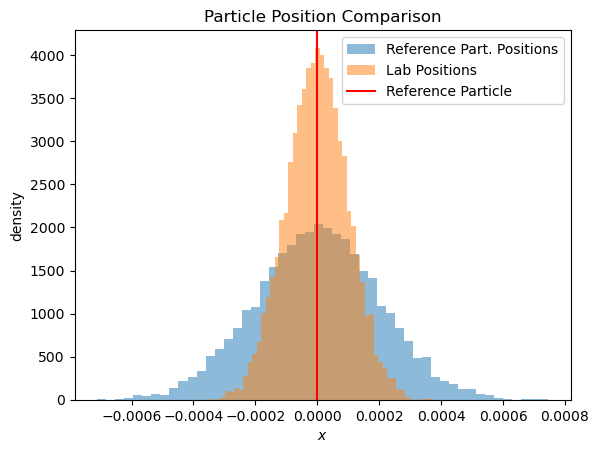

In [10]:
###
# STEP 2: Lorentz boost to the reference particle's frame
###

# Perform the lorentz boost for each particle
for particle in particle_array:
    particle.lorentz_boost_to(reference)

reference.boost_as_reference()

# get the velocities and positions of each particle
lb_particle_vel = np.array([particle.get_3v() for particle in particle_array])
lb_particle_pos = np.array([particle.get_3p()[0] for particle in particle_array])

# get the velocity and position of the reference particle
lb_ref_vel = np.mean(lb_particle_vel, axis=0)[0]
lb_ref_pos = np.mean(lb_particle_pos, axis=0)

plt.xlabel("$x$")
plt.ylabel("density")
plotNormalWithLine(lb_particle_pos[:,2], title="Reference Part. Positions", opacity = 0.5)
plotNormalWithLine(particle_pos[:,2], title="Lab Positions", opacity =0.5)
plt.axvline(x = ref_pos[0], color='r', label = 'Reference Particle')
plt.legend()
plt.title("Particle Position Comparison")

[INFO] NO MESH SPECIFIED. ASSUMING: N=100000,                 RANGE=(-0.0007107063512495792, 0.0007459997397933067)


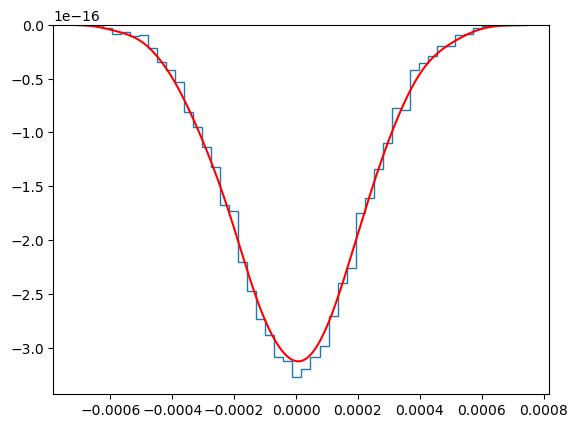

In [11]:
###
# STEP 3: Bin the distribution of particles in the Lorentz-boosted frame
###

# now, I can get the number density of the particles at a certain position
lb_mgf = MultiGaussFit(lb_particle_pos[:,2], nbins=50, ngaussians=50, width=.00005)

# i'll translate this into a charge density
charge_density = lb_mgf.scale_by_factor(Electron.CHARGE.value)

charge_density.plot_fit()

In [12]:
###
# STEP 4: Obtain the Longitudinal & Transverse Electric fields
#
# Take the bunch of particles to be a cylinder, and slice it up. Each slice
# will have a charge density determined by the bunched up particles.
#
###

### PARAMETERS ###

#bunch
bunch_rad = 1E-4  # radius of bunch (aka cylinder), is very thin
bunch_len = charge_density.bins[-1] - charge_density.bins[0]

# meshes
MESH_PTS = 10
step = bunch_len / MESH_PTS

tran_mesh, d_tran = np.linspace(
    start   =-bunch_rad,
    stop    = bunch_rad,
    retstep = True,
    num = MESH_PTS
)

long_mesh = np.arange(
    start =-bunch_len/2,
    stop  = bunch_len/2,
    step  = d_tran
)

x_mesh, y_mesh = tran_mesh, tran_mesh
z_mesh = long_mesh

# number of quadrature points
q_pts = 48

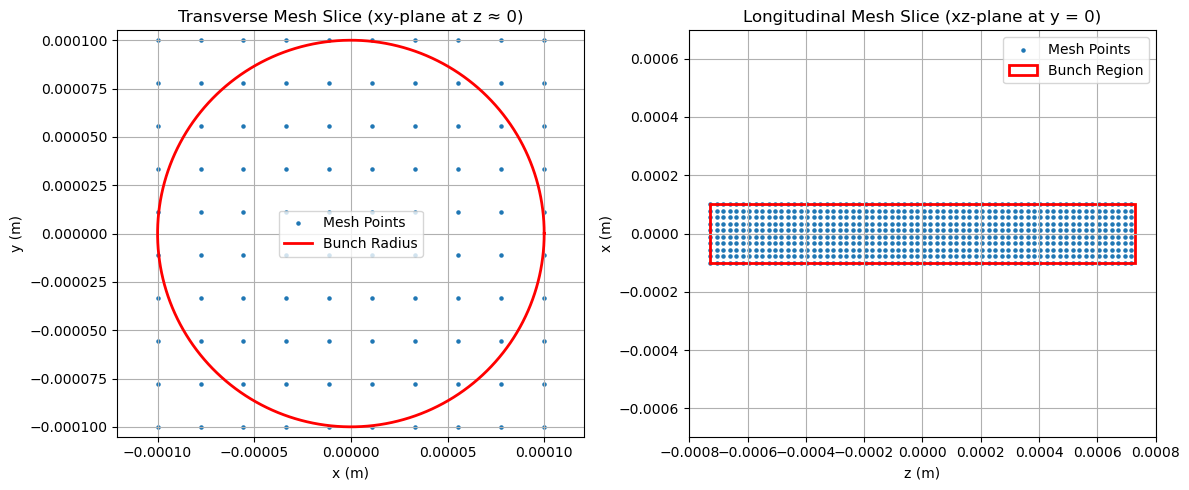

In [13]:
# plot the bunches
import matplotlib.patches as patches

# --- Compute Grids ---
X_xy, Y_xy = np.meshgrid(x_mesh, y_mesh, indexing='ij')
X_xz, Z_xz = np.meshgrid(x_mesh, z_mesh, indexing='ij')

# Circle (bunch cross-section in xy-plane)
theta = np.linspace(0, 2*np.pi, 200)
circle_x = bunch_rad * np.cos(theta)
circle_y = bunch_rad * np.sin(theta)

# Rectangle (bunch cross-section in xz-plane)
z_min = -bunch_len / 2
z_max =  bunch_len / 2
x_min = -bunch_rad
x_max =  bunch_rad

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

### Subplot 1: Transverse (xy) Plane
axs[0].scatter(X_xy, Y_xy, s=5, label='Mesh Points')
axs[0].plot(circle_x, circle_y, 'r-', linewidth=2, label='Bunch Radius')
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')
axs[0].set_title('Transverse Mesh Slice (xy-plane at z ≈ 0)')
axs[0].axis('equal')
axs[0].grid(True)
axs[0].legend()

### Subplot 2: Longitudinal (xz) Plane
axs[1].scatter(Z_xz, X_xz, s=5, label='Mesh Points')
rect = patches.Rectangle(
    (z_min, x_min), bunch_len, 2*bunch_rad,
    linewidth=2, edgecolor='r', facecolor='none', label='Bunch Region'
)
axs[1].add_patch(rect)
axs[1].set_xlabel('z (m)')
axs[1].set_ylabel('x (m)')
axs[1].set_title('Longitudinal Mesh Slice (xz-plane at y = 0)')
axs[1].axis('equal')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

In [14]:
### EVALUATE!!! ###
lb_efld_cyl = np.zeros((len(x_mesh), len(y_mesh), len(z_mesh), 3), dtype=np.float64)

for i_z, z in enumerate(z_mesh):
    print(f"Z: [ {i_z+1}/{len(z_mesh)} ]")
    for i_y, y in enumerate(y_mesh):
        for i_x, x in enumerate(x_mesh):
            lb_efld_cyl[i_x, i_y, i_z] = call_jit_scField(
                field_pt=np.array([x,y,z]),
                bunch_rad=bunch_rad,
                bunch_len=bunch_len,
                n=q_pts,
                rho=charge_density
            )


Z: [ 1/66 ]
Z: [ 2/66 ]
Z: [ 3/66 ]
Z: [ 4/66 ]
Z: [ 5/66 ]
Z: [ 6/66 ]
Z: [ 7/66 ]
Z: [ 8/66 ]
Z: [ 9/66 ]
Z: [ 10/66 ]
Z: [ 11/66 ]
Z: [ 12/66 ]
Z: [ 13/66 ]
Z: [ 14/66 ]
Z: [ 15/66 ]
Z: [ 16/66 ]
Z: [ 17/66 ]
Z: [ 18/66 ]
Z: [ 19/66 ]
Z: [ 20/66 ]
Z: [ 21/66 ]
Z: [ 22/66 ]
Z: [ 23/66 ]
Z: [ 24/66 ]
Z: [ 25/66 ]
Z: [ 26/66 ]
Z: [ 27/66 ]
Z: [ 28/66 ]
Z: [ 29/66 ]
Z: [ 30/66 ]
Z: [ 31/66 ]
Z: [ 32/66 ]
Z: [ 33/66 ]
Z: [ 34/66 ]
Z: [ 35/66 ]
Z: [ 36/66 ]
Z: [ 37/66 ]
Z: [ 38/66 ]
Z: [ 39/66 ]
Z: [ 40/66 ]
Z: [ 41/66 ]
Z: [ 42/66 ]
Z: [ 43/66 ]
Z: [ 44/66 ]
Z: [ 45/66 ]
Z: [ 46/66 ]
Z: [ 47/66 ]
Z: [ 48/66 ]
Z: [ 49/66 ]
Z: [ 50/66 ]
Z: [ 51/66 ]
Z: [ 52/66 ]
Z: [ 53/66 ]
Z: [ 54/66 ]
Z: [ 55/66 ]
Z: [ 56/66 ]
Z: [ 57/66 ]
Z: [ 58/66 ]
Z: [ 59/66 ]
Z: [ 60/66 ]
Z: [ 61/66 ]
Z: [ 62/66 ]
Z: [ 63/66 ]
Z: [ 64/66 ]
Z: [ 65/66 ]
Z: [ 66/66 ]


-- BUNCH --
Length: 0.0014567060910428858, Radius: 0.0001


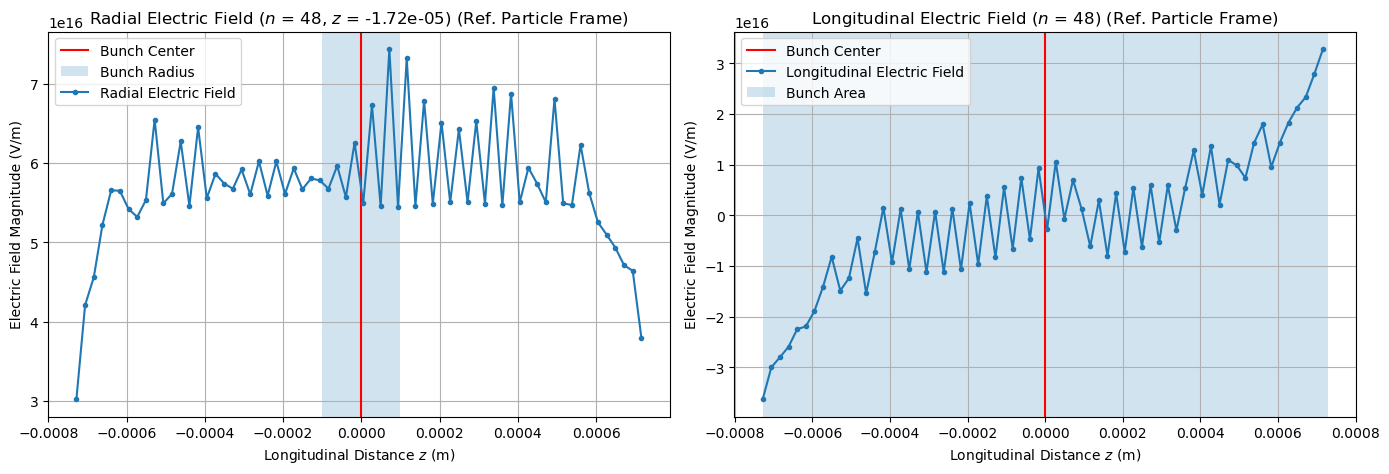

In [54]:
print("-- BUNCH --")
print(f"Length: {bunch_len}, Radius: {bunch_rad}")

def closestVal(val, array, dx = None):
    if dx == None:
        dx = array[1] - array[0]

    # clip val to be in the array
    val = np.clip(val, array[0], array[-1])

    return int((val - array[0])/dx)

idx = closestVal(bunch_rad, x_mesh)
idy = closestVal(0, y_mesh)
idz = closestVal(0, z_mesh)

fig, axs = plt.subplots(1,2, figsize=(14, 5))  # 2 rows, 1 column

# Radial Efld
axs[0].grid()
axs[0].axvline(x=lb_ref_pos[0], label='Bunch Center', color='red')
axs[0].axvspan(-bunch_rad, bunch_rad, alpha=0.2, label='Bunch Radius')
#                       sweep across x at y=z=0
axs[0].plot(z_mesh, lb_efld_cyl[idx, idy, :][:, 0], '.-', label="Radial Electric Field")
axs[0].set_xlabel("Longitudinal Distance $z$ (m)")
axs[0].set_ylabel("Electric Field Magnitude (V/m)")
axs[0].set_title(f"Radial Electric Field ($n$ = {q_pts}, $z$ = {z_mesh[idz]:0.2e}) (Ref. Particle Frame)")
axs[0].legend()

# Longitudinal Efld
axs[1].grid(True)
axs[1].axvline(x=lb_ref_pos[0], label='Bunch Center', color='red')
#                  sweep across z at x = y = 0, extract the z comps
axs[1].plot(z_mesh, lb_efld_cyl[idx, idy, :][:,2], '.-', label="Longitudinal Electric Field")
axs[1].axvspan(-bunch_len/2, bunch_len/2, alpha=0.2, label='Bunch Area')
axs[1].set_xlabel("Longitudinal Distance $z$ (m)")
axs[1].set_ylabel("Electric Field Magnitude (V/m)")
axs[1].set_title(f"Longitudinal Electric Field ($n$ = {q_pts}) (Ref. Particle Frame)")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# get the field at x,y = 0, z = end of bunch. this should be a purely z directional field
print(
    x_mesh[closestVal(0, x_mesh)],
    y_mesh[closestVal(0, y_mesh)],
    z_mesh[closestVal(bunch_len, z_mesh)]
)

lb_efld_cyl[
    closestVal(0, x_mesh),
    closestVal(0, y_mesh),
    closestVal(bunch_len, z_mesh)
]

-1.1111111111111112e-05 -1.1111111111111112e-05 0.0007160913989229997


array([-2.83715620e+15, -4.50143000e+15,  4.92052359e+16])

### Analytical Solutions to the Fields
The shapes that I should be seeing for the radial electric field (which is what I care about) is:

$$
E_R(r, \zeta) \propto r g(\zeta)
$$
where
$$
g(\zeta) = \frac{1-\zeta}{2\sqrt{\alpha^2 + (1-\zeta)^2}} + \frac{\zeta}{2\sqrt{\alpha^2 + \zeta^2}}, \qquad \zeta = \frac{z}{L}, \qquad \alpha = \frac{R}{\gamma L}
$$

and for the transverse

$$
E_z(\zeta) \propto h(\zeta)
$$
where
$$
h(\zeta) = \sqrt{\alpha+(1-\zeta)^2} - \sqrt{\alpha+\zeta^2} + (2\zeta - 1)
$$

In [17]:
# Create functions for the analytical soltuions described above
def zeta(z):
    return z / bunch_len

def alpha(v):
    return bunch_rad / (fv.gamma_3v(v) * bunch_len)

def er_analytical(r, zeta, v_bunch): # the same as g(zeta)
    t1 = (1 - zeta) / (2 * np.sqrt(alpha(v_bunch)**2 + (1 - zeta)**2))
    t2 = zeta / (2 * np.sqrt(alpha(v_bunch)**2 + zeta**2))
    return r * (t1 + t2)

def et_analytical(zeta, v_bunch):
    t1 = np.sqrt(alpha(v_bunch) + (1-zeta)**2)
    t2 = - np.sqrt(alpha(v_bunch) + zeta**2) + 2*zeta - 1
    return t1 + t2

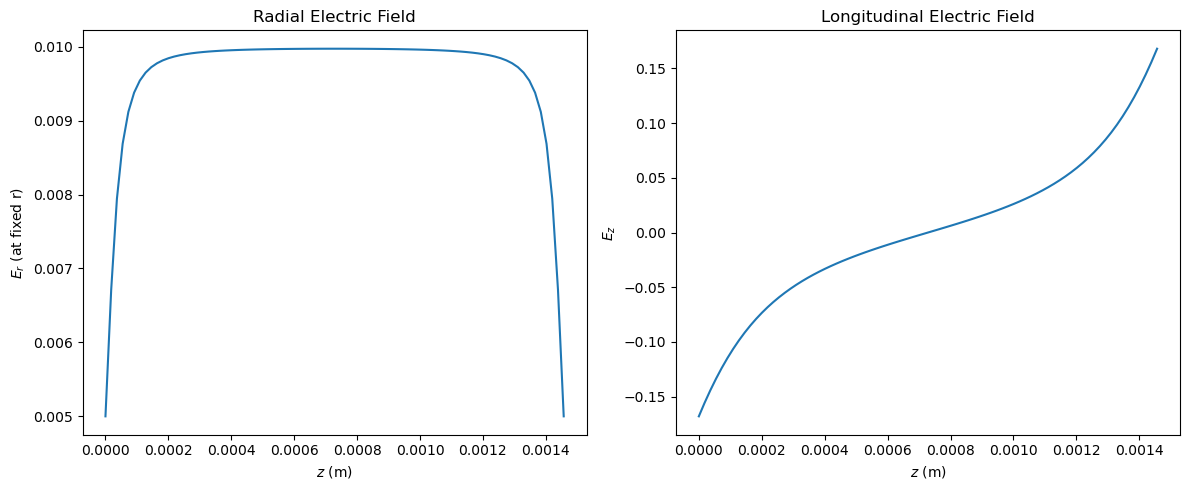

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

z_vals = np.linspace(0, bunch_len, 81)
zeta_vals = zeta(z_vals)

# mult by negative because we have electron bunch
E_R_vals = er_analytical(r=0.01, zeta=zeta_vals, v_bunch=MU_VEL)
E_z_vals = et_analytical(zeta_vals, v_bunch=MU_VEL)


axs[0].plot(z_vals, E_R_vals)
axs[0].set_xlabel("$z$ (m)")
axs[0].set_ylabel("$E_r$ (at fixed r)")
axs[0].set_title("Radial Electric Field")

axs[1].plot(z_vals, E_z_vals)
axs[1].set_xlabel("$z$ (m)")
axs[1].set_ylabel("$E_z$")
axs[1].set_title("Longitudinal Electric Field")

plt.tight_layout()
plt.show()

### Putting it all together
Now, I'll try to plot these solutions against each other. I'll cheat a little bit and scale the analytical ones to fit my bunch.


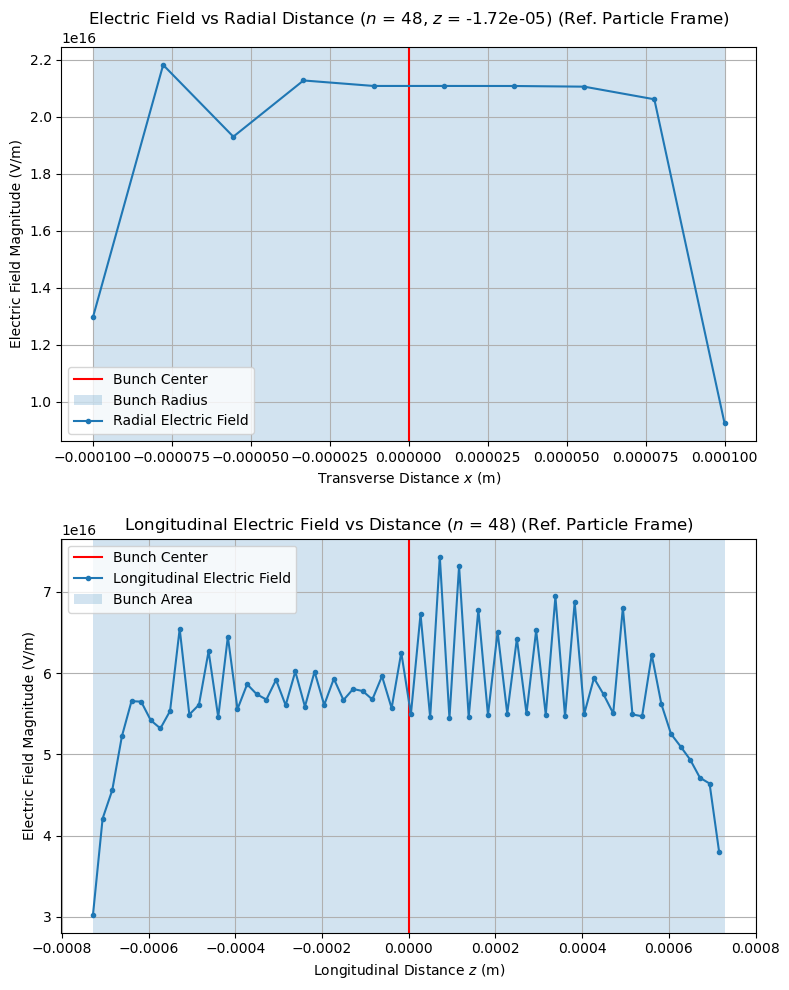

In [19]:

fig, axs = plt.subplots(2, 1, figsize=(8, 10))  # 2 rows, 1 column

# Radial Efld
axs[0].grid()
axs[0].axvline(x=lb_ref_pos[0], label='Bunch Center', color='red')
axs[0].axvspan(-bunch_rad, bunch_rad, alpha=0.2, label='Bunch Radius')
#                       sweep across x at y=z=0
axs[0].plot(x_mesh, lb_efld_cyl[:, idy, idz][:, 2], '.-', label="Radial Electric Field")
axs[0].set_xlabel("Transverse Distance $x$ (m)")
axs[0].set_ylabel("Electric Field Magnitude (V/m)")
axs[0].set_title(f"Electric Field vs Radial Distance ($n$ = {q_pts}, $z$ = {z_mesh[idz]:0.2e}) (Ref. Particle Frame)")
axs[0].legend()

# Longitudinal Efld
axs[1].grid(True)
axs[1].axvline(x=lb_ref_pos[0], label='Bunch Center', color='red')
#                  sweep across z at x = y = 0, extract the z comps
axs[1].plot(z_mesh, lb_efld_cyl[idx, idy, :][:,0], '.-', label="Longitudinal Electric Field")
axs[1].axvspan(-bunch_len/2, bunch_len/2, alpha=0.2, label='Bunch Area')
axs[1].set_xlabel("Longitudinal Distance $z$ (m)")
axs[1].set_ylabel("Electric Field Magnitude (V/m)")
axs[1].set_title(f"Longitudinal Electric Field vs Distance ($n$ = {q_pts}) (Ref. Particle Frame)")
axs[1].legend()

plt.tight_layout()
plt.show()

In [20]:
import matplotlib.animation as animation
from IPython.display import HTML

# Compute magnitude of transverse field
E_perp_mag = np.linalg.norm(lb_efld_r, axis=2)  # shape (Nz, Nr)

# Set up the figure
fig, ax = plt.subplots(figsize=(6, 4))
line, = ax.plot([], [], 'r-')
title = ax.set_title("")
ax.set_xlim(r_mesh[0], r_mesh[-1])
ax.set_ylim(0, 1.1 * np.max(E_perp_mag))
ax.set_xlabel("Radial Distance $r$ (m)")
ax.set_ylabel(r"$|\vec{E}_\perp(r)|$ (V/m)")

# Init function
def init():
    line.set_data([], [])
    title.set_text("")
    return line, title

# Animation update function
def update(i):
    line.set_data(r_mesh, E_perp_mag[i])
    title.set_text(f"Transverse Electric Field at $z$ = {z_mesh[i]:.3e} m")
    return line, title

ani = animation.FuncAnimation(
    fig, update, frames=len(z_mesh), init_func=init,
    interval=100, blit=True
)

HTML(ani.to_jshtml())

NameError: name 'lb_efld_r' is not defined

## Field transforms
The transforms for the fields for a frame moving in the $\hat{z}$ direction are
$$
\boxed{\bar{E}_x = \gamma \left( E_x - v B_y\right) \qquad \bar{E}_y = \gamma (E_y + v B_x) \qquad \bar{E}_z = E_z}
$$
$$
\boxed{\bar{B}_x = \gamma \left(B_x + \frac{v}{c^2} E_y\right) \qquad \bar{B}_y = \gamma \left(B_y - \frac{v}{c^2}E_x\right) \qquad \bar{B}_z = B_z}
$$
and the inverses are obtained by moving in the $-v$ direction
$$
\boxed{E_x = \gamma \left( \bar{E}_x + v \bar{B}_y\right) \qquad E_y = \gamma (\bar{E}_y - v \bar{B}_x) \qquad E_z = \bar{E}_z}
$$
$$
\boxed{B_x = \gamma \left(\bar{B}_x - \frac{v}{c^2} \bar{E}_y\right) \qquad B_y = \gamma \left(\bar{B}_y + \frac{v}{c^2} \bar{E}_x\right) \qquad B_z = \bar{B}_z}
$$

In [ ]:
###
# STEP 5: Test transforming the fields between frames
###

def fieldTransform(efld, bfld, v):
    """Returns the electric and magnetic fields in a frame moving in the *z* direction."""
    efld_bar = np.array([
        fv.gamma_3v(v) * (efld[0] - v * bfld[1]), # x
        fv.gamma_3v(v) * (efld[1] + v * bfld[0]), # y
        efld[2]                                   # z
        ])

    bfld_bar = np.array([
        fv.gamma_3v(v) * (bfld[0] + v * efld[1]/9E16),
        fv.gamma_3v(v) * (bfld[1] - v * efld[0]/9E16),
        bfld[2]
    ])

    return efld_bar, bfld_bar

def inverseFieldTransform(efld_bar, bfld_bar, v):
    """Returns the electric and magnetic fields in the **lab**
       frame from a frame moving in the *z direction"""
    efld = np.array([
        fv.gamma_3v(v) * (efld_bar[0] + v * bfld_bar[1]), # x
        fv.gamma_3v(v) * (efld_bar[1] - v * bfld_bar[0]), # y
        efld_bar[2]                                       # z
        ])

    bfld = np.array([
        fv.gamma_3v(v) * (bfld_bar[0] - v * efld_bar[1]/9E16),
        fv.gamma_3v(v) * (bfld_bar[1] + v * efld_bar[0]/9E16),
        bfld_bar[2]
    ])

    return efld, bfld

In [ ]:
###
# Step 6: Convert the fields in the reference particle frame to cartesian,
#         then convert that into the lab frame using the functions that I defined.
###

ValueError: setting an array element with a sequence.